# Stochastic methods for simulating Brownian motors

We can also write our equation as a stochastic process, the stochastic differential equation that corresponds to our initial PDE with diffusion coefficient $k_B T(x, t) = \frac{\sigma^2(X_t, t)}{2}$ is given by:

$$ dX_t = -V'(X_t, t)dt + \sigma(X_t, t)dW_t $$

Where $W_t$ is the standard Wiener process given by:

$$ W_t = \xi_0 t + \sqrt{2} \sum_{n=1}^\infty \xi_n \frac{\sin(\pi n t)}{\pi n} $$

where $\xi_n$ are independant Gaussian variables with mean zero and variance one. First we will simulate a truncated version of the Wiener process, if all of the particles start at the origin then we should see them spreading out like a Gaussian (simple Brownian motion).

In [ ]:
2+2

In [1]:
using PyPlot
using Interact
using Distributions
# using ForwardDiff
diff_periodic(vec) = [diff(vec) ; diff(vec)[1]]

function discrete_quad(vec, start, fin)
    #Use the trapezoid rule to do quadrature on a vector vec 
    #where the points in vec are evenly spaced from start to fin
    h = (fin - start)/length(vec)
    (h/2)*(vec[1] + vec[end] + 2*sum(vec[2:end-1]))
end
figureDirectory = "C:\\Users\\devja964\\Documents\\Project\\Git\\Honours2016\\Thesis\\Figures"

INFO: Recompiling stale cache file C:\Users\devja964\.julia\lib\v0.4\Distributions.ji for module Distributions.
INFO: Recompiling stale cache file C:\Users\devja964\.julia\lib\v0.4\PDMats.ji for module PDMats.


"C:\\Users\\devja964\\Documents\\Project\\Git\\Honours2016\\Thesis\\Figures"

In [2]:
function wiener(dist, time_vec)
    #Function accepts a Gaussian distribution and some times to evaluate the Wiener process generated by that
    #particular distribution
    s = 0.0
    for i = 1:length(dist)-1
        s += dist[i+1]*(sin(pi*i*time_vec)/(pi*i))
    end
    dist[1]*time_vec + sqrt(2)*s
end

wiener (generic function with 1 method)

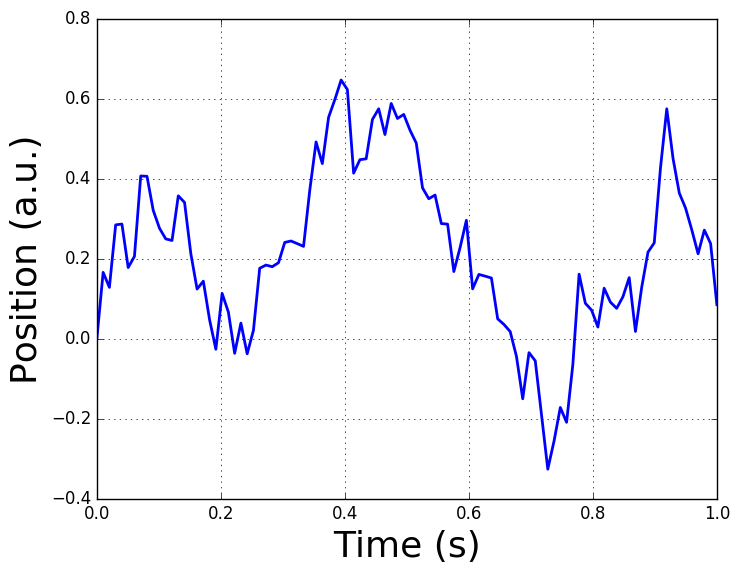

In [38]:
dist = randn(100)
time_axis = linspace(0, 1, 100)
plot(time_axis, wiener(dist, time_axis), linewidth = 2)
grid()
# title("Path for a single particle undergoing a Wiener process for the time interval [0, 1]")
xlabel("Time (s)", fontsize = 26)
ylabel("Position (a.u.)", fontsize = 26)
# savefig("$(figureDirectory)\\singleBrownianTrajectory.pdf")

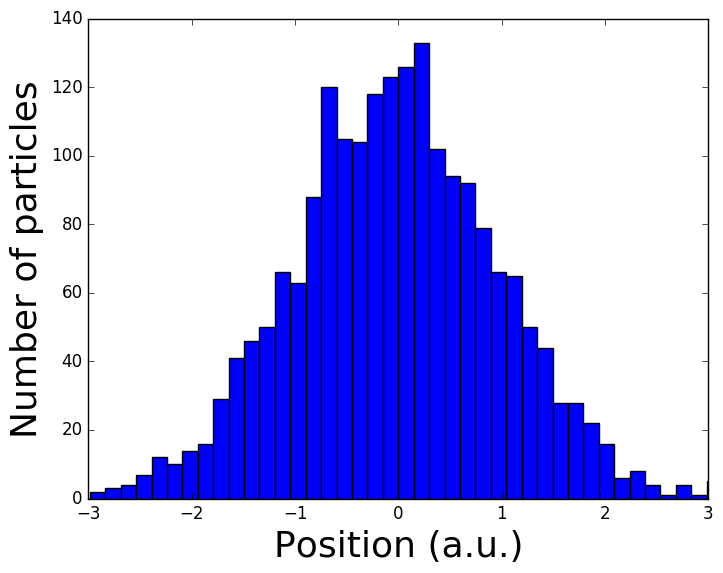

In [42]:
n_particles = 2000
n_steps = 100 #Number of steps that the particle takes (also the point where we truncate the sum)
particles = zeros(n_particles)
count = 1
end_point = Array(Float64, n_particles)
for particle in particles
    end_point[count] = wiener(randn(n_steps), 1.0) #The position of the particle by the end of its walk
    count += 1
end

plt[:hist](end_point, 50)
xlabel("Position (a.u.)", fontsize = 26)
ylabel("Number of particles", fontsize = 26)
xlim([-3, 3])
# savefig("$(figureDirectory)\\multipleBrownianTrajectory.pdf")

# Using the Euler approximation to simulate the uncoupled equation

We have the equation

$$ d X_t = V'(X_t, t)dt + \sqrt{2 k_B T} d W_t $$

The Euler approximation says that:

$$ \hat{X}(t_n + 1) = \hat{X}(t_n) - V'(\hat{X}(t_n), t_n) \Delta t + \sqrt{2 k_B T} \Delta W(t_n) $$

where $t_n = n \Delta t$ $\Delta W(t_n) = W(t_n + 1) - W(t_n)$. $\hat{X}$ approaches $X$ as $\Delta t$ goes to zero. This can be simplified to:

$$ \hat{X}(t_n + 1) = \hat{X}(t_n) - V'(\hat{X}(t_n), t_n) \Delta t + \sqrt{2 k_B T} \sqrt{\Delta t} \xi $$
where $Prob(\xi = -1) = Prob(\xi = 1) = \frac{1}{2}$. The second form is much faster to compute.

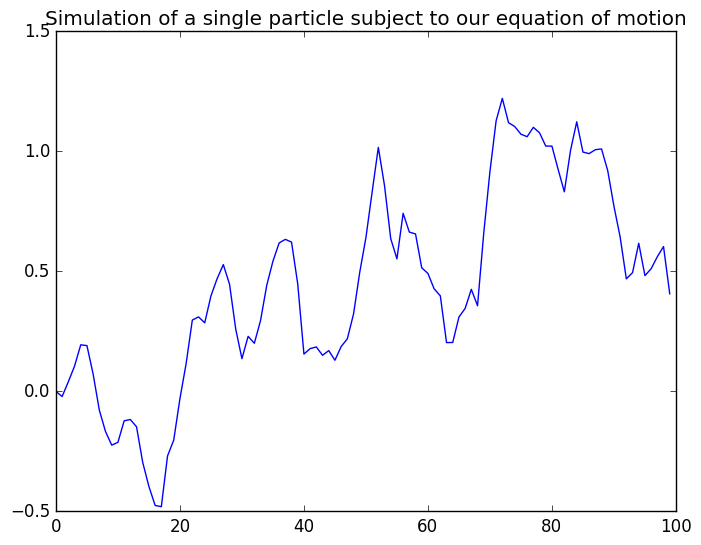

PyObject <matplotlib.text.Text object at 0x0000000028401BA8>

In [43]:
Δt = 0.01
k_B = 1.38e-3
T = 600.0

f = 2.3
v₀ = 1.5
L = 1.0

V(x) = f*x + v₀*sin((2.0*pi/L)*x)

n_steps = Int(1/Δt)
time_axis = linspace(0, 1, n_steps)
X = Array(Float64, n_steps)
X[1] = 0.0
dist = randn(n_steps)
W = wiener(dist, time_axis)

for i = 2:n_steps
    X[i] = X[i-1] + V(X[i-1])*Δt + sqrt(2*k_B*T)*(W[i] - W[i-1])
end

plot(X)
title("Simulation of a single particle subject to our equation of motion")

In [71]:
k_B = 1.38e-3
T = 300.0
T_fun(x) = 300.0 #+ 50*sin((pi/L)*x)

f = 1.3
v₀ = 1.0
L = 1.0

V(x) = f*x + v₀*sin((2.0*pi/L)*x)
dV(x) = f + (2.0*pi/L)*v₀*cos((2.0*pi/L)*x)
ddV(x) = -(2.0*pi/L)^2*v₀*sin((2.0*pi/L)*x)
μ(x) = -(f + (2.0*pi/L)*v₀*cos((2.0*pi/L)*x))
# μ(x) = T

function simulate_particle(init_pos, Δt, μ::Function, T::Number)
    #This is the method for a constant temperature
    n_steps = Int(1/Δt)
    time_axis = linspace(0, 1, n_steps)
    
#     W = wiener(randn(n_steps), time_axis)
#     Y = sqrt(2*k_B*T*Δt)*rand(-1:2:1, n_steps) #The term at the end of the equation
    Y = sqrt(2*k_B*T*Δt)*randn(n_steps)
    X = Array(Float64, n_steps)
    X[1] = init_pos
    for i = 2:n_steps
#         X[i] = X[i-1] + μ(X[i-1])*Δt + sqrt(2*k_B*T)*(W[i] - W[i-1])
        X[i] = X[i-1] + μ(X[i-1])*Δt + Y[i]
    end
    X
end

function simulate_particle(init_pos, Δt, μ::Function, T::Function)
    #This is the method for a non constant temperature, in this case we will have to have T defined at all x,
    #since it is hard to anticipate how far the particle will travel over time.
    n_steps = Int(1/Δt)
    time_axis = linspace(0, 1, n_steps)
    
#     W = wiener(randn(n_steps), time_axis)
#     Y = sqrt(2*k_B*T*Δt)*rand(-1:2:1, n_steps) #The term at the end of the equation
    Y = sqrt(2*k_B*Δt)*randn(n_steps)
    X = Array(Float64, n_steps)
    X[1] = init_pos
    for i = 2:n_steps
#         X[i] = X[i-1] + μ(X[i-1])*Δt + sqrt(2*k_B*T)*(W[i] - W[i-1])
        X[i] = X[i-1] + μ(X[i-1])*Δt + Y[i]*sqrt(T(X[i-1]))
    end
    X
end

simulate_particle (generic function with 2 methods)

In [91]:
n_particles = 1000
total_time = 2
Δt = 0.005
n_steps = Int(1/Δt)*total_time
init_positions = zeros(n_particles)

particle_positions = Array(Float64, n_particles, n_steps)
particle_path = Array(Float64, Int(n_steps/total_time))
count = 1
@time begin
    for position in init_positions
        particle_path[end] = position
        for i = 1:total_time
            particle_path = simulate_particle(particle_path[end], Δt, μ, T_fun)
            indexes = (i*Int(n_steps/total_time)-Int(n_steps/total_time)+1):i*Int(n_steps/total_time)
            particle_positions[count, indexes] = particle_path
        end
        count += 1
    end
end

  0.236441 seconds (7.99 M allocations: 132.339 MB, 4.20% gc time)


In [103]:
# Use this cell for saving the figure and all of the meta data.
time_step = 50
fig_name = "Stochastic"
fig_dir = "C:\\Users\\devja964\\Documents\\Project\\Git\\Honours2016\\Thesis\\Figures"
outfile = open("$(fig_dir)\\$(fig_name).txt", "w")
# Keep track of all of the parameters
message = """Parameters: v_0 = $v₀ \n f = $f \n Bath temperature = $T \n 
            \n number of time steps = $n_steps \n 
            time step size = $Δt"""
write(outfile, message)
close(outfile)

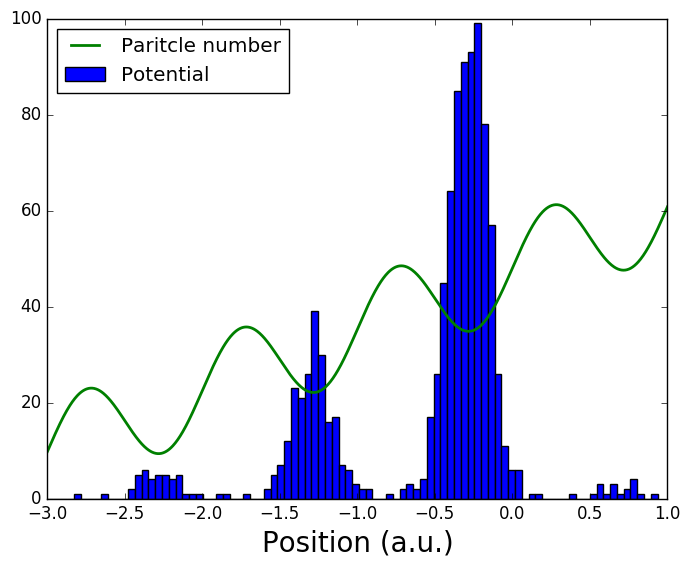

In [104]:
# g = figure()

# @manipulate for i in 1:n_steps withfig(g) do
#         plt[:hist](particle_positions[:, i], 100)
#         plot(x_axis, map(x -> 0.8*(V(x) - f*x_axis[1] + 1.0), x_axis), x_axis, map(x -> 0.1*T_fun(x), x_axis))
#     end
# end
i = 50
x_axis = linspace(-3, 1, 1000)
plt[:hist](particle_positions[:, end], 100)
plot(x_axis, map(x -> 9.8*(V(x) - f*x_axis[1] + 1.0), x_axis), linewidth = 2) #, x_axis, map(x -> 0.1*T_fun(x), x_axis))
legend(["Paritcle number", "Potential"], loc = 2)
xlim([-3, 1])
xlabel("Position (a.u.)", fontsize = 20)
savefig("$fig_dir\\$(fig_name).pdf")

# The two dimensional Wiener process

Consider a particle with coordinates given by $(x_t, y_t) = (W_t^1, W_t^2)$.

In [ ]:
n_steps = 1000
time_axis = linspace(0, 1, n_steps)
dist1 = randn(n_steps)
dist2 = randn(n_steps)
time_axis = linspace(0, 1, n_steps)

plot(wiener(dist1, time_axis), wiener(dist2, time_axis))

In [ ]:
n_particles = 8000
n_steps = 100
x_pos = Array(Float64, n_particles)
y_pos = Array(Float64, n_particles)
for i = 1:n_particles
    dist1 = randn(n_steps)
    dist2 = randn(n_steps)
    x_pos[i] = wiener(dist1, 1.0)
    y_pos[i] = wiener(dist2, 1.0)    
end
hist2D(x_pos, y_pos, 35);

In [ ]:
V(x, y) = f*x + v₀*sin((2.0*pi/L)*x) + f*y + v₀*sin((2.0*pi/L)*y)
μ(x, y) = -(f + (2.0*pi/L)*v₀*cos((2.0*pi/L)*x)) - (f + (2.0*pi/L)*v₀*cos((2.0*pi/L)*y))

function simulate_particle(init_pos::Array, Δt, μ::Function)
    n_steps = Int(1/Δt)
    time_axis = linspace(0, 1, n_steps)
    
#     W = wiener(randn(n_steps), time_axis)
    Y = sqrt(2*k_B*T*Δt)*rand(-1:2:1, 2, n_steps) #The term at the end of the equation
    X = Array(Float64, 2, n_steps)
    X[:, 1] = init_pos
    for i = 2:n_steps
#         X[i] = X[i-1] + μ(X[i-1])*Δt + sqrt(2*k_B*T)*(W[i] - W[i-1])
        X[:, i] = X[:, i-1] + μ(X[:, i-1]...)*Δt + Y[:, i]
    end
    X
end

In [ ]:
path = simulate_particle([0.0 0.0], 0.001, μ)
plot(path[1, :]', path[2, :]')

In [ ]:
n_particles = 1000
Δt = 0.001
n_steps = Int(1/Δt)
init_position = [0.0 0.0]
position = Array(Float64, 2, n_steps, n_particles)

for i = 1:n_particles
    position[:, :, i] = simulate_particle(init_position, Δt, μ)
end

In [ ]:
# g = figure()
# @manipulate for time_step in 1:n_steps withfig(g) do
#     a = Float64[position[1, time_step, particle] for particle = 1:n_particles]
#     b = Float64[position[2, time_step, particle] for particle = 1:n_particles]
#     hist2D(a, b, 70)
#     end
# end

In [ ]:
# ax = imshow([V(x, y) for x in linspace(-5, 2, 100), y in linspace(-5, 2, 100)], extent=[-5, 2, -5, 2])

# Coupling the equation

Here we are couling the equation by saying that (Ignoring diffussion)

$$ T(x, t_{n+1}) = T(x, t_n) + -\kappa \left(\frac{\partial J}{\partial x} \frac{\partial V}{\partial x} + 
     J \frac{\partial^2 V}{\partial x} \right) $$
     
Where, $J(x)$ is the particle current, i.e. the number of particles crossing the point $x$ between times $t_n$ and $t_{n+1}$.

# These cells are really slow because they have the temperature etc as functions, not discrete vectors 

In [ ]:
function stoch_integral(func, lower, upper, n_points)
    #Do a stochastic integral of the function func from lower to upper, i.e. evaluate int_lower^upper func(t) dW(t)
    dt = (upper - lower)/n_points
    dW = sqrt(dt)*randn(1, n_points)
    W = cumsum(dW)
    
    ito = sum([0 ; W[1:end-1]].*dW)
#     strat = sum((0.5*([0 ; W[1:end-1]] + W) + 0.5sqrt(dt)*randn(1, n_points)).*dW)
    
#     itoerr = abs(ito - 0.5*(W[end]^2-T))
#     straterr = abs(strat - 0.5*W[end]^2)
    
    return ito
end

In [ ]:
# delta(x, epsilon) = abs(x) < epsilon ? 1 : 0
delta(x, sigma) = (1/(sigma*sqrt(pi)))*exp(-(x^2)/(2sigma^2))

function simulate_coupled_particle(position, Δt, μ::Function, dV::Function, ddV::Function, T::Function, kappa::Number)
    #Simulate a particle that is coupled to the environment.
    #The particle current at time t_n and position x is one if (X(t_n) < x && X(t_n+1) > x) || ...
    Y = sqrt(2*k_B*Δt)*randn()

    new_position = position + μ(position)*Δt + sqrt(2*k_B*Δt)*randn()*sqrt(T(position))
    
    epsilon = 0.005
    #Should I make the current fuzzy? If it is, then that will affect the derivative of the current
    current(x) = (position < x < new_position) ? 1 : (new_position < x < position) ? -1 : 0
    d_current(x) =  sign(new_position - position)*(delta(x - position, epsilon) - delta(x - new_position, epsilon))
    
    T_new(x) = T(x) - kappa*(d_current(x)*dV(x) + current(x)*ddV(x))
    
    return new_position, T_new
end

In [ ]:
n_steps = 2000
Δt = 0.01
kappa = 0.004
# T_old(x) = 200*exp(-x.^2) + 150
T_old(x) = 250.0 + 50*sin((pi/L)*x)
Temperature = Array(Function, n_steps)
Temperature[1] = T_old
init_pos = 0.0
position = Array(Float64, n_steps)
position[1] = init_pos
old_position = init_pos

init_pos2 = -0.8
position2 = Array(Float64, n_steps)
position2[1] = init_pos2
old_position2 = init_pos2
for i = 2:n_steps
    new_position, Temperature[i] = simulate_coupled_particle(old_position, Δt, μ, dV, ddV, Temperature[i-1], kappa)
    position[i] = new_position
    old_position = new_position
    new_position2, Temperature[i] = simulate_coupled_particle(old_position2, Δt, μ, dV, ddV, Temperature[i-1], kappa)
    position2[i] = new_position2
    old_position2 = new_position2
end 

In [ ]:
#Turn all of those functions into an array that is easier for the manipulate to work with.
n_points = 500 #Number of points to discretize T by for plotting
stride_size = 100 #Number of intervals to ignore T at
x_axis = linspace(-7, 1, n_points)
Temp_array = Array(Float64, n_steps, n_points)
for i = 1:Int(n_steps/stride_size)
    Temp_array[(stride_size*i + 1 - stride_size):(stride_size*i), :] = 
    repmat(map(x -> Temperature[i*stride_size - stride_size + 1](x), x_axis), 1, stride_size)'
end

In [ ]:
# g = figure()
# @manipulate for i in 1:n_steps withfig(g) do
#         plt[:hist]([position[i] position2[i]])
#         plot(x_axis, map(x -> 0.08*(V(x) - f*x_axis[1] + 1.0), x_axis), x_axis, 0.01*Temp_array[i, :]')
#     end
# end

i = n_steps
plt[:hist]([position[i] position2[i]])
plot(x_axis, map(x -> 0.08*(V(x) - f*x_axis[1] + 1.0), x_axis), x_axis, 0.01*Temp_array[i, :]')

# Modeling the diffusion of temperature

If we ignore the interaction of the motor and the environment, then the evolution of the temperature is governed by diffussion, the macroscopic equation for this is given by:

$$ \frac{\partial T}{\partial t} = D \frac{\partial^2 T}{\partial x^2} $$

We will simulate this diffussion using finite differencing.

In [ ]:
#Diffusion of temperature
D = 1.1
function stepTdiff(dis_T, Δt)
    diag_minus1 = Float64[D for j in 2:n_points]
    diag0 = Float64[-2D for j in 1:n_points]
    diag1 = Float64[D for j in 1:n_points-1]
    
    A = spdiagm((diag_minus1, diag0, diag1), (-1, 0, 1))
    A[1, end] = D
    A[end, 1] = D
    (speye(size(A)...) - 0.5*Δt*A)\((speye(size(A)...) + 0.5*Δt*A)*dis_T)
end

In [ ]:
Δt = 0.1
n_steps = 5000
T = Array(Float64, n_points, n_steps)
# T_0 = [300*sin((pi/L)*x) + 600 for x in x_axis]
T_0 = [300*exp(-((x+3.5)^2)/0.5) + 600 for x in x_axis]
T[:, 1] = T_0
for i = 2:n_steps
    time = i*Δt
    dis_T = T[:, i-1]
    T[:, i] = stepTdiff(dis_T, Δt)
end

In [ ]:
# g = figure()
# @manipulate for time_step=1:n_steps withfig(g) do
#         plot(x_axis, T[:, time_step])
#     end
# end

time_step = 100
plot(x_axis, T[:, time_step])

In [ ]:
function simulate_coupled_particle(position, x_axis, Δt, μ::Function, dis_dV::Array, dis_ddV::Array,
    dis_T::Array, kappa::Number, D::Number)
    #Simulate a particle that is coupled to the environment. Use this method for a discretized version of the 
    #temperature where the temperature is calculated at all points at each step, so that the discretized temperature
    #can be used for finite differencing. This means that the x_axis will be restricted.
    #The particle current at time t_n and position x is one if (X(t_n) < x && X(t_n+1) > x) || ...
    Δ = 1/length(dis_T)
    Y = sqrt(2*k_B*Δt)*randn()
    position_index = indmin(abs(x_axis - position))
    
    new_position = position + μ(position)*Δt + sqrt(2*k_B*Δt)*randn()*sqrt(dis_T[position_index])
    new_position_index = indmin(abs(x_axis - new_position))
    
    epsilon = 0.0005
    #Should I make the current fuzzy? If it is, then that will affect the derivative of the current
    current = Float64[(position < x < new_position) ? 1 : (new_position < x < position) ? -1 : 0 for x in x_axis]
    d_current =  Float64[sign(new_position - position)*(delta(x - position, epsilon) - delta(x - new_position, epsilon))
        for x in x_axis]
    
    dis_T = dis_T - kappa*Δt*(d_current.*dis_dV + current.*dis_ddV)
    
    #Now apply diffusion to the temperature
    diag_minus1 = Float64[D for j in 2:n_points]
    diag0 = Float64[-2D for j in 1:n_points]
    diag1 = Float64[D for j in 1:n_points-1]
    
    A = spdiagm((diag_minus1, diag0, diag1), (-1, 0, 1))
    A[1, end] = D
    A[end, 1] = D
    dis_T = (speye(size(A)...) - 0.5*Δt*A)\((speye(size(A)...) + 0.5*Δt*A)*dis_T)
    
    return new_position, dis_T
end

In [ ]:
n_steps = 2000
n_points = 500
Δt = 0.01
kappa = 0.4
D = 0.1
x_axis = linspace(-5, 1, n_points)
# T_old(x) = 200*exp(-x.^2) + 150
# T_old(x) = 250.0 + 50*sin((pi/L)*x)
dis_dV = Float64[dV(x) for x in x_axis]
dis_ddV = Float64[ddV(x) for x in x_axis]
Temperature = Array(Float64, n_steps, n_points)
dis_T = Float64[250.0 + 50*sin((pi/L)*x) for x in x_axis]
Temperature[1, :] = dis_T
init_pos = 0.0
position = Array(Float64, n_steps)
position[1] = init_pos
old_position = init_pos

init_pos2 = -0.2
position2 = Array(Float64, n_steps)
position2[1] = init_pos2
old_position2 = init_pos2
@time begin
    for i = 2:n_steps
        new_position, dis_T = simulate_coupled_particle(old_position, x_axis, Δt, μ, 
                dis_dV, dis_ddV, dis_T, kappa, D)
        position[i] = new_position
        old_position = new_position

        new_position2, dis_T = simulate_coupled_particle(old_position2, x_axis, Δt, μ, 
                dis_dV, dis_ddV, dis_T, kappa, D)
        position2[i] = new_position2
        old_position2 = new_position2

        Temperature[i, :] = dis_T
    end
end

In [ ]:
# g = figure()
# @manipulate for i in 1:n_steps withfig(g) do
#         plt[:hist]([position[i] position2[i]])
#         plot(x_axis, map(x -> 0.08*(V(x) - f*x_axis[1] + 1.0), x_axis), x_axis, 0.01*Temperature[i, :]')
#     end
# end

i = n_steps
plt[:hist]([position[i] position2[i]])
plot(x_axis, map(x -> 0.08*(V(x) - f*x_axis[1] + 1.0), x_axis), x_axis, 0.01*Temperature[i, :]')

In [ ]:
# Run a single coupled particle multiple times
k_B = 1.38e-3 # Boltzmann constant
v0 = 0.9 # Amplitude of the oscillations in the potential
f = 2.5 # Forcing for the potential
D = 0.001 # Diffusion constant for the temperatre
kappa = 0.3 # Heat capacity
L = 1.0 # Length of one period
T0 = 150.0 # Temperature at the ends (i.e. bath temperature)
n_particles = 100
total_time = 2
n_points = 500
dt = 0.01
x_axis = linspace(-5, 1, n_points)

n_steps = Int(1/dt)*total_time
init_positions = rand(Normal(0, 1), n_particles)
particle_positions = Array(Float64, n_particles, n_steps)
particle_positions[:, 1] = init_positions
old_position, new_position = init_positions[1], init_positions[1]

V(x) = f*x + v0*sin((2.0*pi/L)*x)
dV(x) = f + (2.0*pi/L)*v0*cos((2.0*pi/L)*x)
ddV(x) = -(2.0*pi/L)^2*v0*sin((2.0*pi/L)*x)
μ(x) = -(f + (2.0*pi/L)*v0*cos((2.0*pi/L)*x))

dis_V = Float64[V(x) for x in x_axis]
dis_dV = Float64[dV(x) for x in x_axis]
dis_ddV = Float64[ddV(x) for x in x_axis]
dis_T = Float64[T0 + 50*sin((pi/L)*x) for x in x_axis]
dis_T_cum = zeros(size(dis_T)...)
@time begin
    for particle in 1:n_particles
        dis_T = Float64[250.0 + 50*sin((pi/L)*x) for x in x_axis]
        old_position = particle_positions[particle]
        new_position = particle_positions[particle]
        for i = 2:n_steps
            new_position, dis_T = simulate_coupled_particle(old_position, x_axis, dt, μ, 
                    dis_dV, dis_ddV, dis_T, kappa, D)
            old_position = new_position
            particle_positions[particle, i] = new_position
            
            if i == n_steps
                dis_T_cum += dis_T
            end
        end
    end
end
dis_T_cum = dis_T_cum/n_steps;

In [ ]:
time_step = n_steps
plt[:hist](particle_positions[:, time_step], 25)
plot(x_axis, -f*x_axis[1] + dis_V)
plot(x_axis, dis_T_cum)

In [ ]:
plot(particle_positions[1, :]')

In [ ]:
rand(Normal(1, 2), 100)